In [1]:
__author__ = 'Brian Merino <brian.merino@noirlab.edu>'
__version__ = '2024' # yyyymmdd; version datestamp of this notebook
__keywords__ = ['Aladin','smash','des','delve']

# Displaying MOCs and HiPs in Aladin Lite v3

## Table of contents
* [Goals](#goals)
* [Summary](#summary)
* [Disclaimers and attribution](#disclaimer)
* [Imports and setup](#imports)
* [Create MOCs](#Create_MOCs)
* [About the dataset](#About)
* [Downloading data for reduction](#Downloading_Data)
* [Set up the DRAGONS logger](#DRAGONS_logger)
* [Create File Lists](#File_Lists)
* [Create Master Dark](#Master_dark)
* [Create Bad Pixel Mask](#BPM)
* [Create Master Flat Field](#Master_Flat)
* [Reduce Science Images](#Reduce_Science)
* [Display stacked final image](#Display_Image)
* [Clean-up (optional)](#Clean-up)

<a class="anchor" id="goals"></a>
# Goals
Showcase how to create Multi-Order Coverage maps (MOCs) and Hierarchical Progressive Surveys (HiPS) and display them on the Aladin Lite viewer.

The steps include downloading data from the Astro DataLab's data explorer, turning the data into MOCs and HiPs files, establish a local instance of the Aladin Lite viewer, and finally, display the files and explorer Aladin.


<a class="anchor" id="summary"></a>
# Summary
Aladin Lite is an interactable sky atlas that runs in your browser. 

Aladin makes it possible to explore the sky and has built in functionality that makes it possible to overlay images onto the map and identify objects included in databases. 

HiPS catalogs make it possible to see the locations of objects on the sky while MOCs display the footprints of surveys. MOCs make it possible to visualize overlaps in various surveys.

This notebook will demonstrate how to create and overlay several MOC files onto Aladin which would help identify overlapping datasets. It could also assist in preparing for a telescope proposal as you would be able to see whether or not any of the datasets hosted by the datalab contain the source of interest. 

In addition to MOCs, this notebook will also generate and display HiPs catlogs. While MOCs visualize survey footprints, HiPS will identify individual sources and provide information about each source when you place your curser over their points on Aladin. 


<a class="anchor" id="disclaimer"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., <a href="http://dx.doi.org/10.1117/12.2057445">"The NOAO Data Laboratory: a conceptual overview"</a>, SPIE, 9149, 2014

* <a href="https://datalab.noirlab.edu/disclaimers.php">Data Lab disclaimer</a>

* DRAGONS publication: Labrie et al., <a href="https://ui.adsabs.harvard.edu/abs/2019ASPC..523..321L/abstract">"DRAGONS - Data Reduction for Astronomy from Gemini Observatory North and South"</a>, ASPC, 523, 321L 

* <a href="https://zenodo.org/record/7776065#.ZDg5qOzMLUI">DRAGONS open source software publication</a>

<a class="anchor" id="imports"></a>
# Imports and setup

This is the setup that is required to use the query client. The first thing to do is import the relevant Python modules.

In [2]:
!pip install ipyaladin mocpy

In [1]:
# Standard lib
from getpass import getpass

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

import astropy.units as u
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.wcs import WCS
from astropy.table import Table
from astropy.table import QTable

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from mocpy import MOC

from ipyaladin import Aladin

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Accessing the data

To create the MOC that we will ultimately overlay onto Aladin, we are going to use the mocpy library. 

The first thing we will need to do is obtain the data from the Astro Data Lab. For this example, we will be working with data from three different surveys; The **DE**Cam **L**ocal **V**olume **E**xploration Survey [**DELVE**](https://datalab.noirlab.edu/delve/index.php), The **S**urvey of the **MA**gellanic **S**tellar **H**istory [**SMASH**](https://datalab.noirlab.edu/smash/smash.php), and The **D**ark **E**negery **S**urvey [**DES**](https://datalab.noirlab.edu/des/index.php).

# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [2]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
#print(token)
ac.whoAmI()

'anonymous'

In [3]:
query = 'SELECT TOP 25000 ra, dec, mag_auto_g, random_id FROM des_dr2.main WHERE random_id BETWEEN 25.0 AND 25.01'
#response = qc.query(sql = query, fmt = 'csv', out='vos://des_dr2.csv')
df = qc.query(sql = query, fmt = 'pandas')

#Lets add an additional column assigning a unique index to each data point.
df['index'] = list(range(0,len(df)))

df['survey'] = 'des_dr2'

print('des_dr2 catalog')
print (df)

des_dr2 catalog
               ra        dec  mag_auto_g  random_id  index   survey
0      357.428715 -44.637259   23.489162  25.000000      0  des_dr2
1        5.969949 -43.527294   24.286612  25.000000      1  des_dr2
2       22.207492 -32.286238   25.298033  25.000000      2  des_dr2
3       29.788967 -32.981351   21.148296  25.000000      3  des_dr2
4       20.727107  -2.892649   25.397202  25.000000      4  des_dr2
...           ...        ...         ...        ...    ...      ...
24995   54.172207 -27.747459   24.843880  25.003592  24995  des_dr2
24996   84.988716 -43.217000   27.056932  25.003592  24996  des_dr2
24997   84.363729 -40.298618   26.280462  25.003592  24997  des_dr2
24998   88.931305 -36.130207   99.000000  25.003592  24998  des_dr2
24999   88.376329 -31.771497   23.679323  25.003592  24999  des_dr2

[25000 rows x 6 columns]


In [4]:
query2 = 'SELECT TOP 25000 ra, dec, mag_auto_g, random_id FROM delve_dr2.objects WHERE random_id BETWEEN 25.0 AND 25.01'
#response2 = qc.query(sql = query2, fmt = 'csv', out='vos://delve_dr2.csv')
df2 = qc.query(sql = query2, fmt = 'pandas')

#Lets add an additional column assigning a unique index to each data point.
df2['index'] = list(range(0,len(df2)))

df2['survey'] = 'delve_dr2'

print('delve_dr2 catalog')
print (df2)

delve_dr2 catalog
               ra        dec  mag_auto_g  random_id  index     survey
0      316.881741 -28.795287   99.000000  25.000000      0  delve_dr2
1      316.551473  -0.040920   99.000000  25.000000      1  delve_dr2
2      352.731892 -15.496893   99.000000  25.000000      2  delve_dr2
3       24.796882 -38.515716   99.000000  25.000000      3  delve_dr2
4       41.790499 -35.662513   23.775738  25.000000      4  delve_dr2
...           ...        ...         ...        ...    ...        ...
24995  223.429216   0.261509   20.466070  25.000996  24995  delve_dr2
24996  232.832520 -15.321605   19.765182  25.000996  24996  delve_dr2
24997  233.947717  -0.094942   99.000000  25.000996  24997  delve_dr2
24998  236.617734  -1.914219   21.536312  25.000996  24998  delve_dr2
24999  250.666405 -10.360976   99.000000  25.000996  24999  delve_dr2

[25000 rows x 6 columns]


In [5]:
query3 = 'SELECT TOP 25000 ra, dec, gmag, random_id FROM smash_dr2.object WHERE random_id BETWEEN 25.0 AND 25.01'
#response3 = qc.query(sql = query3, fmt = 'csv', out='vos://smash_dr2.csv')
df3 = qc.query(sql = query3, fmt = 'pandas')

#Lets add an additional column assigning a unique index to each data point.
df3['index'] = list(range(0,len(df3)))

df3['survey'] = 'smash_dr2'

print('smash_dr2')
print (df3)

smash_dr2
               ra        dec       gmag  random_id  index     survey
0      162.189122 -27.937445  25.859041  25.000000      0  smash_dr2
1        8.216296 -72.550729  22.301060  25.000000      1  smash_dr2
2      141.331479 -24.322865  25.586674  25.000004      2  smash_dr2
3      150.680861 -75.469131  26.583921  25.000004      3  smash_dr2
4      129.785524 -73.123489  99.990000  25.000004      4  smash_dr2
...           ...        ...        ...        ...    ...        ...
24995   26.184753 -70.696753  99.990000  25.007020  24995  smash_dr2
24996  164.082881 -17.483517  25.556486  25.007025  24996  smash_dr2
24997  225.871730 -83.724109  99.990000  25.007025  24997  smash_dr2
24998  248.948190 -83.268695  21.105180  25.007025  24998  smash_dr2
24999  144.480733 -78.573200  21.523542  25.007025  24999  smash_dr2

[25000 rows x 6 columns]


In [6]:
query4 = 'SELECT TOP 25000 ra, dec, f378_petro, random_id FROM splus_dr2.main WHERE random_id BETWEEN 25.0 AND 25.1'
#response3 = qc.query(sql = query3, fmt = 'csv', out='vos://smash_dr2.csv')
df4 = qc.query(sql = query4, fmt = 'pandas')

#Lets add an additional column assigning a unique index to each data point.
df4['index'] = list(range(0,len(df4)))

df4['survey'] = 'splus_dr2'

print('splus_dr2')
print (df4)

splus_dr2
               ra        dec  f378_petro  random_id  index     survey
0      337.923287  -0.507185   15.869586  25.000006      0  splus_dr2
1       10.236303  -0.546833   99.000000  25.000006      1  splus_dr2
2       47.316315  -0.070461   22.031181  25.000006      2  splus_dr2
3      164.513442 -21.220074   22.089874  25.000006      3  splus_dr2
4      160.648219 -29.604460   99.000000  25.000011      4  splus_dr2
...           ...        ...         ...        ...    ...        ...
24995  327.903064  -0.308875   29.534716  25.080278  24995  splus_dr2
24996   40.839044  -1.169043   24.632952  25.080294  24996  splus_dr2
24997  213.765808 -26.102858   22.972174  25.080294  24997  splus_dr2
24998  209.389865  -4.497503   99.000000  25.080294  24998  splus_dr2
24999   43.573658   0.282823   99.000000  25.080303  24999  splus_dr2

[25000 rows x 6 columns]


In [7]:
query5 = 'SELECT TOP 25000 ra, dec, mean_r, random_id FROM decaps_dr2.object WHERE random_id BETWEEN 25.0 AND 25.1'
df5 = qc.query(sql = query5, fmt = 'pandas')

#Lets add an additional column assigning a unique index to each data point.
df5['index'] = list(range(0,len(df5)))

df5['survey'] = 'decaps_dr2'

print('decaps_dr2')
print (df5)

decaps_dr2
               ra        dec        mean_r  random_id  index      survey
0        8.553123 -42.927057  0.000000e+00    25.0000      0  decaps_dr2
1      114.443078 -40.798236  1.650980e-09    25.0000      1  decaps_dr2
2      115.131645 -40.723081  1.790090e-08    25.0000      2  decaps_dr2
3      113.604821 -39.452238  5.239570e-10    25.0000      3  decaps_dr2
4      115.565516 -39.006055  0.000000e+00    25.0000      4  decaps_dr2
...           ...        ...           ...        ...    ...         ...
24995  190.878514 -57.215436  0.000000e+00    25.0007  24995  decaps_dr2
24996  186.835906 -56.607810  0.000000e+00    25.0007  24996  decaps_dr2
24997  187.294264 -57.607615  9.778530e-10    25.0007  24997  decaps_dr2
24998  186.853616 -57.321865  1.429870e-08    25.0007  24998  decaps_dr2
24999  186.878981 -57.756968  1.143380e-09    25.0007  24999  decaps_dr2

[25000 rows x 6 columns]


# Now that all three datasets have been downloaded, we can now create Multi-Order Coverage maps (MOCs) for each of them using the mocpy library. 

In [103]:
def prepare(columns, dataframe, max_norder):
    '''
    This function will perform 2 tasks:
    (1) Read in columns of a dataframe and output a dictionary that is compatible with Aladin Lite

    (2) Use the ra and dec info from the dictionary to create a MOC.
    '''
    #Define a dictionary
    col_dict = {}
    
    #Read each item in provided list and extract the values from the dataframe. Assign values to dictionary.
    for c in columns:
        col_dict[c] = dataframe[c].values
        
    #Now we are going to establish our MOC  
    #Provide MOC.from_longlat() with ra and dec in degrees
    #max_norder:The depth of the smallest HEALPix cells contained in the MOC. Min = 1 | Max = 10
    moc = MOC.from_lonlat(
              col_dict['ra'].transpose() * u.deg,
              col_dict['dec'].transpose() * u.deg,
              max_norder=max_norder)

    return col_dict, moc

In [102]:
des_list = ['ra','dec','index','mag_auto_g','survey']
des_dict, des_dr2_moc = prepare(des_list, df, max_norder=5)

In [95]:
delve_list = ['ra','dec','index','mag_auto_g','survey']
delve_dict, delve_dr2_moc = prepare(delve_list, df2, max_norder=5)

In [96]:
smash_list = ['ra','dec','index','gmag','survey']
smash_dict, smash_dr2_moc = prepare(smash_list, df3, max_norder=5)

In [97]:
splus_list = ['ra','dec','index','f378_petro','survey']
splus_dict, splus_dr2_moc = prepare(splus_list, df4, max_norder=5)

In [98]:
decaps_list = ['ra','dec','index','mean_r','survey']
decaps_dict, decaps_dr2_moc = prepare(decaps_list, df5, max_norder=5)

In [99]:
def plot(moc, color, legend, title=""):
    fig = plt.figure(figsize=(15, 10))

    for c,m in enumerate(moc):
        wcs = WCS(naxis=2)
        wcs.wcs.ctype = ["GLON-AIT", "GLAT-AIT"] #Hammer-Aitoff projection
        wcs.wcs.crval = [300.0, 0.0]             #Specify the value of the reference pixel
        wcs.wcs.cdelt = [-0.675, 0.675]
        wcs.wcs.crpix = [240.5, 120.5]
    
        if c == 0:
            ax = fig.add_subplot(1, 1, 1, projection=wcs, frame_class=EllipticalFrame)
            patches = []
    
        m.fill(
            ax=ax,
            wcs=wcs,
            edgecolor=color[c],
            facecolor=color[c],
            linewidth=1.0,
            fill=True,
            alpha=0.5,
        )
        m.border(ax=ax, wcs=wcs, color="black", alpha=1)
    
        plt.xlabel("ra")
        plt.ylabel("dec")
        if title:
            plt.title(title)
        plt.grid(color="black", linestyle="dotted")
        
        patches.append(mpatches.Patch(color=color[c], label=legend[c]))
        plt.legend(handles=patches)
        
    plt.show()
    plt.close()

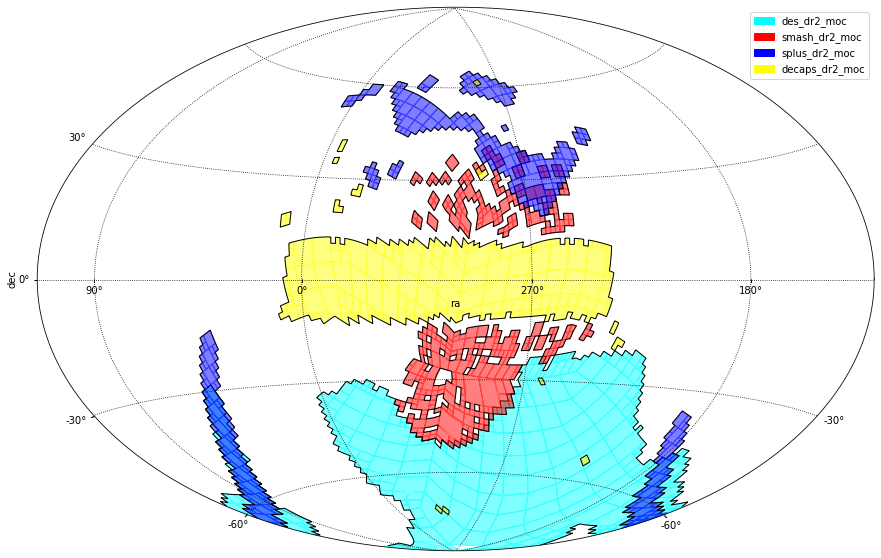

In [100]:
moc = [des_dr2_moc, smash_dr2_moc, splus_dr2_moc, decaps_dr2_moc]
legend = ['des_dr2_moc', 'smash_dr2_moc', 'splus_dr2_moc', 'decaps_dr2_moc']
colors = ['cyan', 'red', 'blue', 'yellow', 'purple']
plot(moc,title='',color=colors,legend=legend)

# Now that we have seen the footprint for each of the three surveys, lets see what they look like in Aladin.

In [48]:
aladin = Aladin(fov=2)
aladin

/Users/brian.merino/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/brian.merino/.local/lib/python3.8/site-packages/traitlets/traitlets.py:842: DeprecationWarning: Deprecated in traitlets 4.1, use the instance .metadata dictionary directly, like x.metadata[key] or x.metadata.get(key, default)
  warn("Deprecated in traitlets 4.1, " + msg, DeprecationWarning, stacklevel=2)


Aladin(fov=2.0, init_options=['background_color', 'coo_frame', 'fov', 'full_screen', 'grid_color', 'grid_opaci…

# With Aladin initialized within the notebook, we will now need to add the mocs to it. Note, you do not need to call aladin after it has been initialized. Using add_moc will update the cell that is displaying Aladin. 

In [23]:
aladin.add_moc(des_dr2_moc, color='red',   name='des_dr2_moc', opacity=0.4)
aladin.add_moc(smash_dr2_moc, color='blue',  name='smash_dr2_moc', opacity=0.4)
aladin.add_moc(splus_dr2_moc, color='green', name='splus_dr2_moc', opacity=0.4)
aladin.add_moc(decaps_dr2_moc, color='yellow', name='decaps_dr2_moc', opacity=0.4)

# Now lets plot the individual sources onto Aladin. Currently, Aladin Lite only works reliably with QTables. So we are going to reformat our pandas dataframes into something the Aladin viewer will accept. 

In [60]:
#des_dr2
des_table    = QTable([des_dict['ra'],des_dict['dec'],des_dict['index'],\
                      des_dict['mag_auto_g'],des_dict['survey']],\
                      names=["ra","dec","index","mag_auto_g","survey"])

#smash_dr2
smash_table  = QTable([smash_dict['ra'],smash_dict['dec'],smash_dict['index'],\
                      smash_dict['gmag'],smash_dict['survey']],\
                      names=["ra","dec","index","gmag","survey"])

#splus_dr2
splus_table  = QTable([splus_dict['ra'],splus_dict['dec'],splus_dict['index'],\
                      splus_dict['f378_petro'],splus_dict['survey']],\
                      names=["ra","dec","index","f378_petro","survey"])

#decaps_dr2
decaps_table = QTable([decaps_dict['ra'],decaps_dict['dec'],decaps_dict['index'],\
                      decaps_dict['mean_r'],decaps_dict['survey']],\
                      names=["ra","dec","index","mean_r","survey"])

### Now we can add our newly reformatted datatables to the Aladin viewer. 

In [61]:
aladin.add_table(des_table,name='des_dr2')
aladin.add_table(smash_table,name='smash_dr2')
aladin.add_table(splus_table,name='splus_dr2')
aladin.add_table(decaps_table,name='decaps_dr2')

### By now, your Aladin viewer maybe hard to read since there are many MOCs and individual data points plotted ontop of each other. You can remove some of these objects by clicking the 'Overlays menu' in your Aladin viewer. A dropdown menu will appear displaying the names of all the MOCs and data tables currently being displayed. From there, you can hover your mouse over any item and either click on the 'eye' icon to hide the object, or the 'trash' icon to fully remove it from the viewer. 

![Pointing out the location of the hide and remove icons in Aladin Lite.](Remove_layer.png "Remove layer.")